In [1]:
import numpy as np
import os
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from skimage.segmentation import quickshift
import skimage.data as data
import skimage.segmentation as seg
from skimage import filters
from skimage import draw
from skimage import color
from skimage import exposure
#own function
from functions_ccdc import *
import time as time 
import scipy as sp

#need for gaussian process example at least
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ExpSineSquared, ConstantKernel
from sklearn.neighbors import LocalOutlierFactor

from scipy.interpolate import interp1d

# CCDC anomaly detection

Here I run my own implemenentation. 

It is currently something between CCDC and COLD plus some own choices not exactly what is implemented elsewhere. 

In [2]:
df=pd.read_csv('armazones_resampled_v1.csv.gz')

FileNotFoundError: [Errno 2] No such file or directory: 'armazones_resampled_v1.csv.gz'


Data shape should be channels, times, pixels because of heritage. That could be changed but is kept, there is is a function now  

In [ ]:
dates,xydata,rdata,meta=reshape_for_ccdc(df,exclude_start=0,exclude_end=0)



Getting the 6 main feature types, for the down sampled data.  Lake, forest, bulding, meadow, construction, logging 
of charlottesville. 

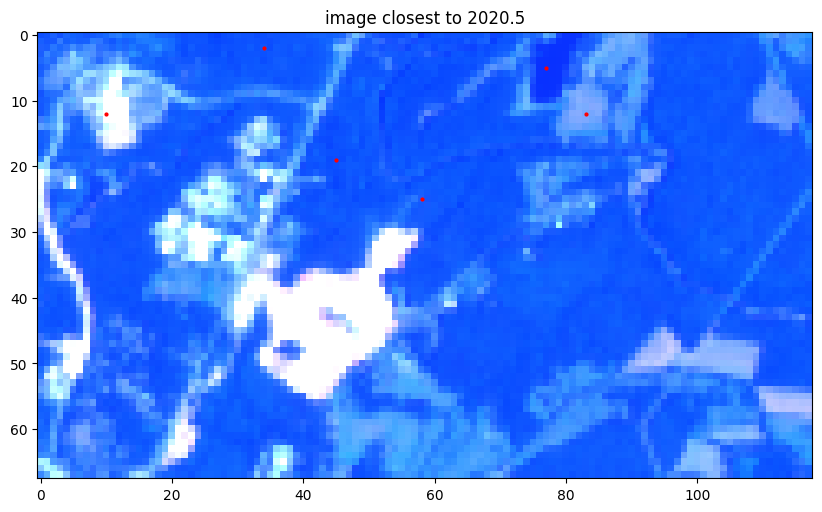

In [ ]:
examples=[[45,19],[77,5],[10,12],[83,12],[58,25],[34,2]]
list_type=['forest','lake','building','meadow','construction','logging']
display_image_back(df,time_el=0,exclude=2,examples=examples,time_date=2020.5,time_axis_direct=False)

In [ ]:
list_ex=coords_el(examples,xydata)
print(list_ex)

[2287, 667, 1426, 1499, 3008, 270]


Fit the main examples. 

In [ ]:
start_time=time.time()
#emulating the irginal version wher all initial fit are in the same time segment
fit_ex0,st_ex0,an_ex0,truth_vec0,range0=ccdc_v1(rdata,dates,list_ex[0],meta,function='harmonic1',init_per=1.0,inter_per=1.15,fin_per=1.0)
stop_time=time.time()
print(stop_time-start_time)
print(range0,an_ex0)

0.6430306434631348
[[2020.43888911    0.            0.            0.        ]
 [2025.08678697    0.            0.            0.        ]] 0


Is working. 

In [ ]:
start_time=time.time()
#now standard decreasing period during fit start
fit_ex0,st_ex0,an_ex0,truth_vec0,range0=ccdc_v1(rdata,dates,list_ex[0],meta,function='harmonic1')
stop_time=time.time()
print(stop_time-start_time)
print(range0,an_ex0)

0.6034204959869385
[[2020.43888911    0.            0.            0.        ]
 [2025.08678697    0.            0.            0.        ]] 0


Is working, now use of that version below. 

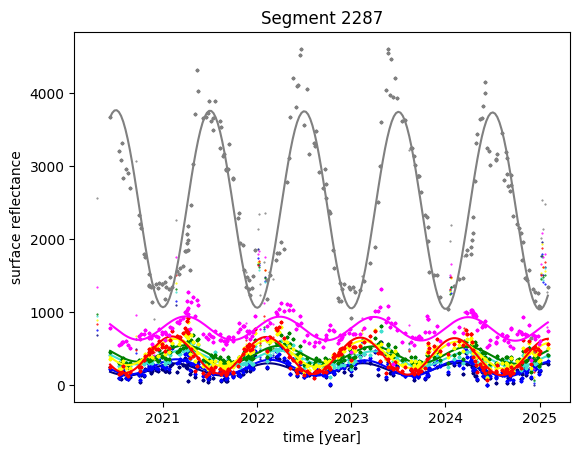

In [ ]:
plot_data_fit(dates,rdata,list_ex[0],truth_vec0,fit_ex0,range0,flags=True)

Is working. 

In [ ]:
start_time=time.time()
fit_ex4,st_ex4,an_ex4,truth_vec4,range4=ccdc_v1(rdata,dates,list_ex[4],meta)
stop_time=time.time()
print(stop_time-start_time)
print(range4,an_ex4)

0.46854209899902344
[[2020.43888911 2023.31959668    0.            0.        ]
 [2023.30316375 2025.08678697    0.            0.        ]] 1


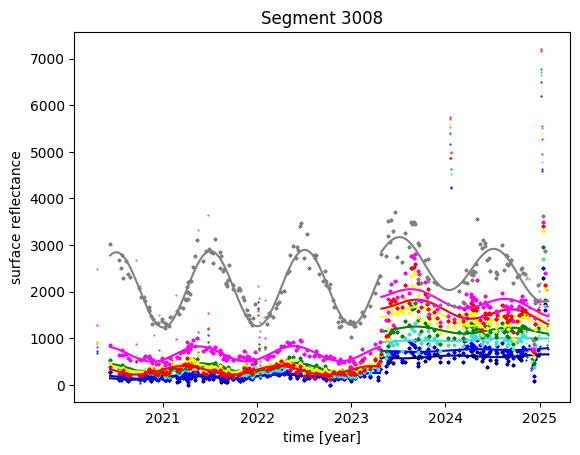

In [ ]:
plot_data_fit(dates,rdata,list_ex[4],truth_vec4,fit_ex4,range4,flags=True)

Is also working for anomalies. 

In [ ]:
start_time=time.time()
fit_ex5,st_ex5,an_ex5,truth_vec5,range5=ccdc_v1(rdata,dates,list_ex[5],meta,print_yes=False)
stop_time=time.time()
print(stop_time-start_time)
print(range5,an_ex5 )

0.37779855728149414
[[2020.43888911 2023.25650799    0.            0.        ]
 [2023.20178903 2024.47170218    0.            0.        ]] 2


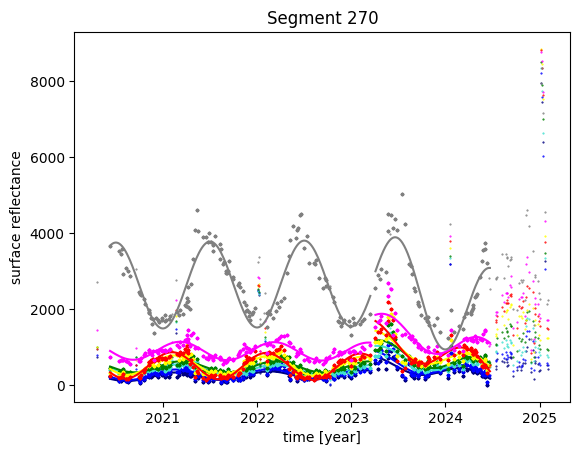

In [ ]:
plot_data_fit(dates,rdata,list_ex[5],truth_vec5,fit_ex5,range5,flags=True)

Two breaks here, is also working. 

Find a data point on the right.

In [ ]:
# Generate reversed indices using coords_el
reversed_indices = coords_el(coors, tensor)[::-1]  # Reverse the output

# Run plot_time_space for each reversed index
for index in reversed_indices:
    element = (tensor[1, index], tensor[0, index])  # Convert index back to (x, y)
    plot_time_space(data, element)

Fit that. 

In [ ]:
start_time=time.time()
fit_ex,st_ex,an_ex,truth_vec,range_test=ccdc_v1(rdata,dates,1285,meta,print_yes=False)
stop_time=time.time()
print(stop_time-start_time)
print(range_test,an_ex )

0.6216766834259033
[[2020.43888911    0.            0.            0.        ]
 [2025.08678697    0.            0.            0.        ]] 0


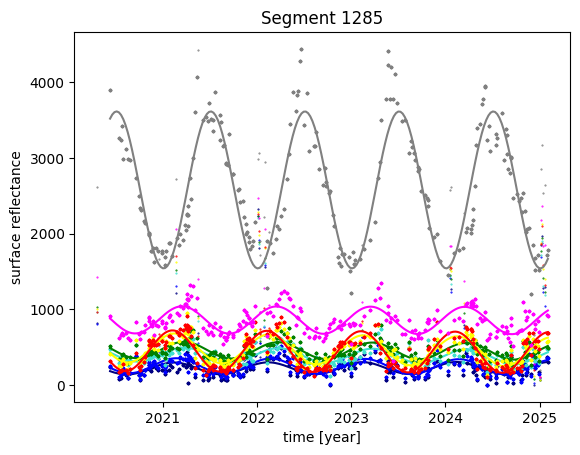

In [ ]:
plot_data_fit(dates,rdata,1285,truth_vec,fit_ex,range_test,flags=True)

Is now working with standard settung, gthus no more experiment needed, and also no need of excluding the first data point in time which is usually bad, but that sems now recognized automatically, at least for these test cases. 

## Full run

Running on all data now, also including the first frame. 

In [ ]:
#loading the data 
df=pd.read_csv('amazones_resampled_v1.csv.gz')
#reshaping
dates,xydata,rdata,meta=reshape_for_ccdc(df,exclude_start=0,exclude_end=0)
#actual running, when all should be i_end should not be given or 0
start_time=time.time()
# function is define which function is fit
#needed_anomalies the number of consecutire outliers needed for an anomaly
#these two should be the most important parameters
fit_data=run_ccdc_many(rdata,dates,meta,xydata,function='harmonic1',needed_anomalies=4,i_end=200)
print(fit_data.shape)
stop_time=time.time()
print(f"total running time is {np.round(stop_time-start_time,3)} sec")
print(f"running time per element is {np.round((stop_time-start_time)/2,3)} sec")
print(f"predicted running time for all is {np.round((stop_time-start_time)/2*rdata.shape[2],3)} sec")
#fit_data.to_csv("northe_point_ccdc_down_nout4_har1_v1.csv")

0


/home/tobias/spectral_anomaly/capstone_projects/ANOMALOUS/functions_ccdc.py:524: RuntimeWarning: invalid value encountered in true_divide
  rat17=data[0,:]/data[6,:]
/home/tobias/spectral_anomaly/capstone_projects/ANOMALOUS/functions_ccdc.py:525: RuntimeWarning: invalid value encountered in true_divide
  rat28=data[1,:]/data[7,:]


1
(2, 404)
total running time is 1.463
running time per element is 0.732
predicted running time for all is 5870.932


/home/tobias/spectral_anomaly/capstone_projects/ANOMALOUS/functions_ccdc.py:614: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[vec]=outliers[i,:]
/home/tobias/spectral_anomaly/capstone_projects/ANOMALOUS/functions_ccdc.py:614: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_res[vec]=outliers[i,:]
/home/tobias/spectral_anomaly/capstone_projects/ANOMALOUS/functions_ccdc.py:614: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

Seems to work. 

But takes time. 13663 second for all 8024 elements for 3 harmonics function, less for 1 harmonic, about 5900 seconds

The official implementations should be faster, because they use hidden C which is faster for many purposes